# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [1]:
import requests
import json
import numpy as np
import pandas as pd

In [2]:
URL = "https://wind-bow.glitch.me/twitch-api/channels/"
channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]

In [3]:
twitch_channels = []

for channel in channels:
    JSONContent = requests.get(URL + channel).json()
    twitch_channel = URL + channel
    if 'error' not in JSONContent:
        twitch_channels.append({
            'id': JSONContent['_id'], 
            'display_name': JSONContent['display_name'], 
            'status': JSONContent['status'],
            'followers': JSONContent['followers'], 
            'views': JSONContent['views']
        })
    #print(JSONContent)
#print(twitch_channels)

In [4]:
dataset = pd.DataFrame(twitch_channels)
dataset.head()

,id,display_name,status,followers,views
0,30220059,ESL_SC2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,OgamingSC2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,FreeCodeCamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

https://apps.apple.com/us/app/tinder-dating-new-people/id547702041

https://apps.apple.com/us/app/twitter/id333903271

https://apps.apple.com/us/app/facebook/id284882215

https://apps.apple.com/us/app/candy-crush-saga/id553834731

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

In [5]:
countries_2 = ['us','ca','gb','au']
app_ids = ['553834731','547702041','284882215','333903271']
dict_app_ids = {'553834731':[], '547702041':[]}

for i in range(1,3):
    for country in countries_2:
        for app_id in app_ids:
            JSONContent1 = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={app_id}/page={str(i)}/sortby=mostrecent/json").json()
            dict_app_ids[app_id] = dict_app_ids.get(app_id,[]);
            for entry in enumerate(JSONContent1['feed']['entry']):
                obj = {'id': app_id, 'review': entry[1]['content']['label'], 'countryCode': country }
                dict_app_ids[app_id].append(obj)
dict_app_ids

{'553834731': [{'id': '553834731',
   'review': 'Perdí todo mi juego iva por 3000 cambie de teléfono y se desconectó todo  volví a bajar el juego pero es empezar de nuevo que puedo hacer?',
   'countryCode': 'us'},
  {'id': '553834731',
   'review': 'Candy crush is designed to make you lose the level and then make you pay for lives when you run out of them. It’s extremely frustrating.',
   'countryCode': 'us'},
  {'id': '553834731',
   'review': 'Hi I love this game I’m not really far into it,so how far is this game?\nU can respond to this if you want to... gave this app five stars because it’s really really fun maybe you can make a second one.',
   'countryCode': 'us'},
  {'id': '553834731',
   'review': 'Advice to any one that’s frustrated with the game and how impossible it is to beat 1 level delete reinstall and play offline',
   'countryCode': 'us'},
  {'id': '553834731',
   'review': 'I love this app because it keeps me entertained when I am bored.',
   'countryCode': 'us'},
  {'


### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

In [ ]:
# countries_2 = ['us','ca','gb','au']
# app_ids = ['553834731','547702041','284882215','333903271']
# dict_app_ids_VR = {'553834731':None, '547702041':None,'284882215':None,'333903271':None}

# for i in range(1,3):
#     for country in countries_2:
#         for app_id in app_ids:
#             JSONContent1 = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={app_id}/page={str(i)}/sortby=mostrecent/json").json()
#             print(JSONContent1)
#             dict_app_ids_VR[app_id] = []
#             for entry in enumerate(JSONContent1['feed']['entry']):
#                 dict_app_ids_VR[app_id].append({
#                     'version': entry[1]['im:version']['label'],
#                     'rating': entry[1]['im:rating']['label']
#                 })

In [7]:
countries_2 = ['us','ca','gb','au']
app_ids = ['553834731','547702041','284882215','333903271']
dict_app_ids_VR = {'553834731':[], '547702041':[],'284882215':[],'333903271':[]}

for i in range(1,3):
    for country in countries_2:
        for app_id in app_ids:
            JSONContent1 = requests.get(f"https://itunes.apple.com/{country}/rss/customerreviews/id={app_id}/page={str(i)}/sortby=mostrecent/json").json()
            dict_app_ids_VR[app_id] = dict_app_ids_VR.get(app_id,[])
            for entry in enumerate(JSONContent1['feed']['entry']):
                dict_app_ids_VR[app_id].append({
                    'version': entry[1]['im:version']['label'],
                    'rating': entry[1]['im:rating']['label']
                })

Candy Crush version
1.184.1.2    4.500000
1.196.0.1    3.082645
1.186.0.3    3.000000
1.193.0.2    2.956522
1.194.0.2    2.953488
1.196.1.1    2.766667
1.191.0.2    2.750000
1.192.0.1    2.708333
1.185.0.1    2.666667
1.188.0.4    2.615385
1.190.0.2    2.500000
1.195.1.1    2.435897
1.189.0.2    2.333333
1.187.1.1    2.000000
Name: rating, dtype: float64


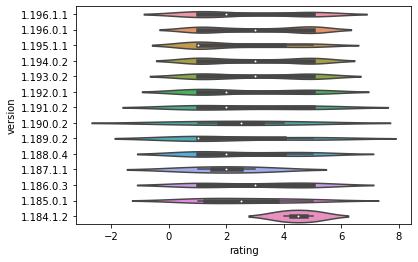

Tinder version
11.31.0    1.651163
12.2.0     1.647059
12.1.0     1.435484
           1.000000
Name: rating, dtype: float64


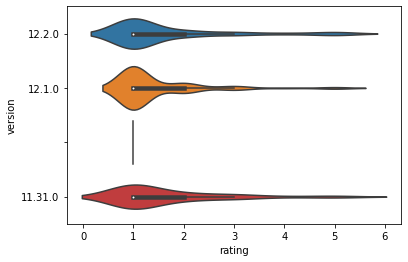

Facebook version
307.0    1.279412
306.0    1.193182
Name: rating, dtype: float64


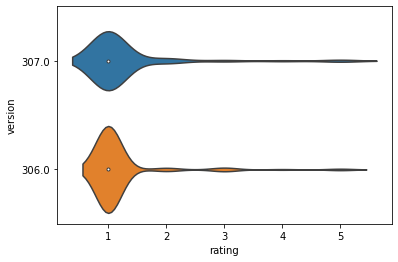

Twitter version
8.53      3.083333
8.54      2.862500
8.54.5    2.813793
8.52.1    2.594828
8.52      2.111111
8.51      1.769231
Name: rating, dtype: float64


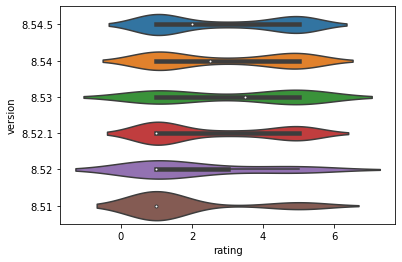

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

lst_id = [('Candy Crush', '553834731'),('Tinder','547702041'),('Facebook','284882215'),('Twitter','333903271')]

def min_max(name,id_one):
    jsoncontent3 = dict_app_ids_VR[id_one]
    df = pd.DataFrame.from_dict(jsoncontent3)
    df['rating'] =  df['rating'].astype(float)
    #print(df['version'])
    print(name, df.groupby('version').rating.mean().sort_values(ascending=False))
    sns.violinplot(x=df['rating'], y =df['version'])
    plt.show()

for tup in lst_id:
    name = tup[0]
    id_1 = tup[1]
    min_max(name, id_1)

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

In [9]:
#Candy Crush Saga
for i in range(1,3):
    req = requests.get(f"https://itunes.apple.com/us/rss/customerreviews/id=553834731/page={str(i)}/sortby=mostrecent/json")

    d = json.loads(req.content)
    df = pd.DataFrame(d['feed']['entry'])
    df['title'] = df['title'].apply(lambda x: x['label'])
    df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
    df['im:version'] = df['im:version'].apply(lambda x: x['label'])


    df1 = df[(df['im:rating'] == '1') | (df['im:rating'] == '5')].copy()
    df2 = df1[['im:rating','title']]
    dummies = df2.title.str.get_dummies(' ')
    print(dummies.sum(axis=0).sort_values(ascending=False)[0:1])

but    4
dtype: int64
game    5
dtype: int64


In [10]:
#Tinder

for i in range(1,3):
    req = requests.get(f"https://itunes.apple.com/us/rss/customerreviews/id=547702041/page={str(i)}/sortby=mostrecent/json")

    d = json.loads(req.content)
    df = pd.DataFrame(d['feed']['entry'])
    df['title'] = df['title'].apply(lambda x: x['label'])
    df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
    df['im:version'] = df['im:version'].apply(lambda x: x['label'])


    df1 = df[(df['im:rating'] == '1') | (df['im:rating'] == '5')].copy()
    df2 = df1[['im:rating','title']]
    dummies = df2.title.str.get_dummies(' ')
    print(dummies.sum(axis=0).sort_values(ascending=False)[0:1])
    

and    6
dtype: int64
is    5
dtype: int64


In [13]:
#Facebook
for i in range(1,3):
    req = requests.get(f"https://itunes.apple.com/us/rss/customerreviews/id=284882215/page={str(i)}/sortby=mostrecent/json")

    d = json.loads(req.content)
    df = pd.DataFrame(d['feed']['entry'])
    df['title'] = df['title'].apply(lambda x: x['label'])
    df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
    df['im:version'] = df['im:version'].apply(lambda x: x['label'])

    df1 = df[(df['im:rating'] == '1') | (df['im:rating'] == '5')].copy()
    df2 = df1[['im:rating','title']]
    dummies = df2.title.str.get_dummies(' ')
    print(dummies.sum(axis=0).sort_values(ascending=False)[0:1])
    

Censorship    12
dtype: int64
Censorship    10
dtype: int64


In [14]:
#Twitter
for i in range(1,3):
    req = requests.get(f"https://itunes.apple.com/us/rss/customerreviews/id=333903271/page={str(i)}/sortby=mostrecent/json")

    d = json.loads(req.content)
    df = pd.DataFrame(d['feed']['entry'])
    df['title'] = df['title'].apply(lambda x: x['label'])
    df['im:rating'] = df['im:rating'].apply(lambda x: x['label'])
    df['im:version'] = df['im:version'].apply(lambda x: x['label'])


    df1 = df[(df['im:rating'] == '1') | (df['im:rating'] == '5')].copy()
    df2 = df1[['im:rating','title']]
    dummies = df2.title.str.get_dummies(' ')
    print(dummies.sum(axis=0).sort_values(ascending=False)[0:1])
    

Censorship    6
dtype: int64
Twitter    4
dtype: int64


# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`